# PaySim-XGboost

In [ ]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics & utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, \
                            precision_recall_curve, classification_report, \
                            confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV


## Models
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

Using TensorFlow backend.


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# Checking data
csvfile_path = '/content/drive/MyDrive/PS_log.csv'
data = pd.read_csv(csvfile_path)

raw_data = data.copy()

print ("raw data shape:", raw_data.shape)
print(raw_data.head())
print(raw_data.describe())
print(raw_data.info())

raw data shape: (6362620, 11)
   step      type      ...        isFraud isFlaggedFraud
0     1   PAYMENT      ...              0              0
1     1   PAYMENT      ...              0              0
2     1  TRANSFER      ...              1              0
3     1  CASH_OUT      ...              1              0
4     1   PAYMENT      ...              0              0

[5 rows x 11 columns]
               step        amount       ...             isFraud  isFlaggedFraud
count  6.362620e+06  6.362620e+06       ...        6.362620e+06    6.362620e+06
mean   2.433972e+02  1.798619e+05       ...        1.290820e-03    2.514687e-06
std    1.423320e+02  6.038582e+05       ...        3.590480e-02    1.585775e-03
min    1.000000e+00  0.000000e+00       ...        0.000000e+00    0.000000e+00
25%    1.560000e+02  1.338957e+04       ...        0.000000e+00    0.000000e+00
50%    2.390000e+02  7.487194e+04       ...        0.000000e+00    0.000000e+00
75%    3.350000e+02  2.087215e+05       ...  

In [ ]:
# PR-AUC curve

# %% Function for plotting PR_AUC curve
def plot_precision_recall(y_test: np.array, y_score: np.array) -> None:
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    auc_score = auc(recall, precision)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall curve: AUC={0:0.4f}'.format(auc_score))
    plt.show()

# Notebooks

## xgboost-auc-0-99831

In [ ]:
data_used = raw_data.loc[(raw_data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
data_used.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

data_used = data_used.reset_index(drop=True)

type_encoder = preprocessing.LabelEncoder()
type_category = type_encoder.fit_transform(data_used['type'].values)
data_used['type_code'] = type_category

print ("data_used shape:", data_used.shape)
data_used.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


data_used shape: (2770409, 8)


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_code
0,TRANSFER,181.00,181.0,0.0,0.0,0.00,1,1
1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0
2,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,0
3,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,1
4,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [ ]:
# under sample
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 
                 'oldbalanceDest', 'newbalanceDest', 'type_code']
number_records_fraud = len(data_used[data_used['isFraud'] == 1])

#　indices of fraud_indices
fraud_indices = data_used[data_used['isFraud'] == 1].index.values

#indices of the normal records
nonfraud_indices = data_used[data_used['isFraud'] == 0].index

random_nonfraud_indices = np.random.choice(nonfraud_indices, number_records_fraud, replace=False)
random_nonfraud_indices = np.array(random_nonfraud_indices)

under_sample_indices = np.concatenate([fraud_indices, random_nonfraud_indices])
under_sample_data = data_used.iloc[under_sample_indices, :]
                          
print(under_sample_data[feature_names].head())
X_undersample = under_sample_data[feature_names].values
y_undersample = under_sample_data['isFraud'].values
print("--------------------------------------------------------------------------")

print("Ratio of nomal: ", len(under_sample_data[under_sample_data['isFraud'] == 0]) / len(under_sample_data))
print("Ratio of fraud: ", len(under_sample_data[under_sample_data['isFraud'] == 1]) / len(under_sample_data))
print("Number of data for model: ", len(under_sample_data))

      amount  oldbalanceOrg    ...      newbalanceDest  type_code
0      181.0          181.0    ...                 0.0          1
1      181.0          181.0    ...                 0.0          0
123   2806.0         2806.0    ...                 0.0          1
124   2806.0         2806.0    ...                 0.0          0
192  20128.0        20128.0    ...                 0.0          1

[5 rows x 6 columns]
--------------------------------------------------------------------------
Ratio of nomal:  0.5
Ratio of fraud:  0.5
Number of data for model:  16426


In [ ]:
X = data_used.drop(['isFraud', 'type'],axis=1)
y = data_used['isFraud']
print(X.head(),"\n")
print(y.head())

      amount  oldbalanceOrg    ...      newbalanceDest  type_code
0     181.00          181.0    ...                0.00          1
1     181.00          181.0    ...                0.00          0
2  229133.94        15325.0    ...            51513.44          0
3  215310.30          705.0    ...                0.00          1
4  311685.89        10835.0    ...          2719172.89          1

[5 rows x 6 columns] 

0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### XGBoost

In [ ]:
XGBoost_CLF = xgb.XGBClassifier(learning_rate =0.1, n_estimators=100, max_depth=6, min_child_weight=1,  
                  gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                  nthread=4, scale_pos_weight=1, seed=42)

In [ ]:
XGBoost_CLF.fit(X_train, y_train)
y_pred = XGBoost_CLF.predict(X_test)

Classification Report for XGBoost Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    828627
           1       0.99      0.72      0.83      2496

   micro avg       1.00      1.00      1.00    831123
   macro avg       0.99      0.86      0.92    831123
weighted avg       1.00      1.00      1.00    831123

Confusion Matrix of XGBoost Classifier: 
 [[828601     26]
 [   693   1803]]


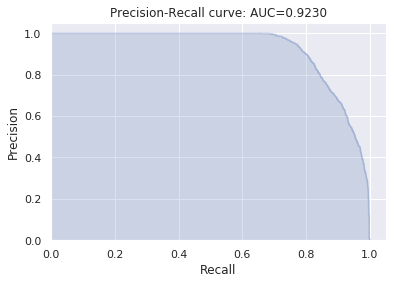

In [ ]:
print("Classification Report for XGBoost Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost Classifier: \n", confusion_matrix(y_test, y_pred))
plot_precision_recall(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

## simple-prediction

In [ ]:
meta_data = pd.read_csv("/content/drive/MyDrive/PS_log.csv")
del meta_data['nameDest']
del meta_data['nameOrig']
del meta_data['type']

In [ ]:
Cols = meta_data[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFlaggedFraud']]
y = meta_data['isFraud']
X = Cols

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## predicting-fraud-in-financial-payment-services

In [ ]:
df = pd.read_csv("")
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type      ...        isFraud isFlaggedFraud
0     1   PAYMENT      ...              0              0
1     1   PAYMENT      ...              0              0
2     1  TRANSFER      ...              1              0
3     1  CASH_OUT      ...              1              0
4     1   PAYMENT      ...              0              0

[5 rows x 11 columns]


In [ ]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

In [ ]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.2, \
                                                random_state = randomState)

#### XGB classifier

In [ ]:
# Long computation in this cell (~1.8 minutes)
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = xgb.XGBClassifier(max_depth = 3, scale_pos_weight = weights, \
                n_jobs = 4)
clf.fit(trainX, trainY)

y_pred = clf.predict(testX)

Classification Report for XGBoost Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552412
           1       0.90      1.00      0.95      1670

   micro avg       1.00      1.00      1.00    554082
   macro avg       0.95      1.00      0.97    554082
weighted avg       1.00      1.00      1.00    554082

Confusion Matrix of XGBoost Classifier: 
 [[552237    175]
 [     3   1667]]


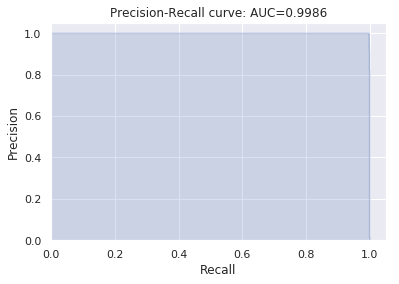

In [ ]:
print("Classification Report for XGBoost Classifier: \n", classification_report(testY, y_pred))
print("Confusion Matrix of XGBoost Classifier: \n", confusion_matrix(testY, y_pred))
plot_precision_recall(testY, clf.predict_proba(testX)[:,1])